In [1]:
#Time series data of WR6 from TESS - 2nd part
import os, sys

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker

import numpy as np

import astropy
from astropy.io import fits
from astropy.io import ascii
import astropy.units as u
# from astropy.utils.data import get_pkg_data_filename   #time-series extraction tool
# from astropy.timeseries import TimeSeries

import math 

import lightkurve as lk    #good time-series library

import pandas as pd 

from scipy.optimize import curve_fit
from scipy.optimize import minimize

import emcee
import corner

from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum

C:\Users\MKH\Documents\Anaconda\lib\site-packages\stingray\largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(
C:\Users\MKH\Documents\Anaconda\lib\site-packages\stingray\crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
C:\Users\MKH\Documents\Anaconda\lib\site-packages\stingray\crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
C:\Users\MKH\Documents\Anaconda\lib\site-packages\stingray\bispectrum.py:10: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [2]:
#read from manually downloaded data from MAST
hd_lc3 = lk.read('tess2020351194500-s0033-0000000078959225-0203-s_lc.fits')
hd_lc3

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2201.7365241590974,3.5486006e+05,6.5638977e+01,3.6651974e-03,701480,984.66563,1273.72614,3.4390112e+05,6.3347481e+01,4.3349907e+03,1.0142013e+01,3.5486006e+05,6.5638977e+01,0,nan,nan,nan,nan,984.66563,1.8296612e-04,1273.72614,1.8123898e-04,3.0650045e-03,-2.0611186e-04
2201.739302019686,3.5499888e+05,6.5650040e+01,3.6652815e-03,701482,984.66449,1273.73562,3.4397697e+05,6.3358162e+01,4.3606440e+03,1.0171767e+01,3.5499888e+05,6.5650040e+01,0,nan,nan,nan,nan,984.66449,1.8284554e-04,1273.73562,1.8140170e-04,2.4483295e-03,8.8432748e-03
2201.740690949864,3.5484359e+05,6.5638046e+01,3.6653234e-03,701483,984.66834,1273.72507,3.4392353e+05,6.3346584e+01,4.3228047e+03,1.0145348e+01,3.5484359e+05,6.5638046e+01,0,nan,nan,nan,nan,984.66834,1.8300524e-04,1273.72507,1.8134067e-04,6.4641433e-03,-1.9154266e-03
2201.7420798800417,3.5478069e+05,6.5641075e+01,3.6653653e-03,701484,984.66438,1273.73012,3.4391816e+05,6.3349510e+01,4.3338115e+03,1.0158043e+01,3.5478069e+05,6.5641075e+01,0,nan,nan,nan,nan,984.66438,1.8296750e-04,1273.73012,1.8108102e-04,1.9257803e-03,3.9743185e-03
2201.7434688104527,3.5467344e+05,6.5635124e+01,3.6654074e-03,701485,984.66679,1273.72671,3.4382800e+05,6.3343765e+01,4.3296709e+03,1.0157616e+01,3.5467344e+05,6.5635124e+01,0,nan,nan,nan,nan,984.66679,1.8306490e-04,1273.72671,1.8112814e-04,4.7680079e-03,6.5804354e-04
2201.744857740631,3.5504331e+05,6.5651375e+01,3.6654493e-03,701486,984.66674,1273.72832,3.4405403e+05,6.3359444e+01,4.3424912e+03,1.0154523e+01,3.5504331e+05,6.5651375e+01,0,nan,nan,nan,nan,984.66674,1.8290262e-04,1273.72832,1.8137523e-04,4.4608423e-03,1.1219596e-03
2201.746246671041,3.5494550e+05,6.5643036e+01,3.6654915e-03,701487,984.66575,1273.73348,3.4392909e+05,6.3351398e+01,4.3341465e+03,1.0158109e+01,3.5494550e+05,6.5643036e+01,0,nan,nan,nan,nan,984.66575,1.8295317e-04,1273.73348,1.8167625e-04,4.0135300e-03,6.6288826e-03
2201.7476356012194,3.5492812e+05,6.5651688e+01,3.6655334e-03,701488,984.67038,1273.72970,3.4408244e+05,6.3359749e+01,4.3301665e+03,1.0139992e+01,3.5492812e+05,6.5651688e+01,0,nan,nan,nan,nan,984.67038,1.8298697e-04,1273.72970,1.8108910e-04,8.3634295e-03,3.5818901e-03


In [3]:
hd_lc3.filename

'tess2020351194500-s0033-0000000078959225-0203-s_lc.fits'

Trying to obtain the PDCSAP flux from the time series. However, a little bit of context first.

- **SAP light curve** is summing together the brightness of pixels that fall within an aperture set by any of these survey missions - referred to as the **optimal aperture**, though, still subject to systematic artifacts of the respective mission.

- **PDCSAP light curve** has more treatment than SAP. The PDCSAP pipeline attempts to remove systematic artifacts while keeping planetary transits intact (made with planet detection intentions)

Text(0.5, 1.0, 'PDCSAP Light Curve of HD 050896 - ts3')

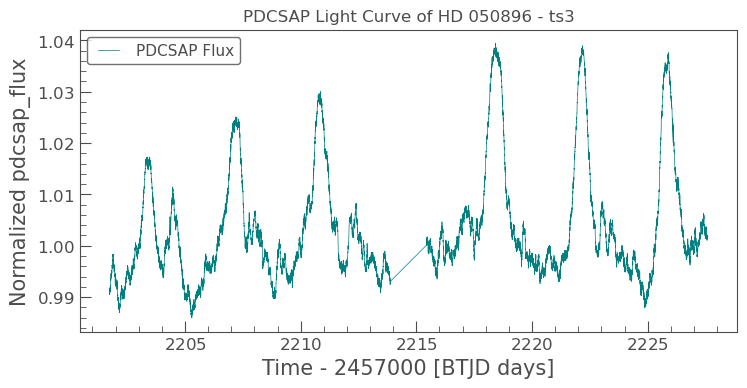

In [4]:
ax = hd_lc3.plot(column='pdcsap_flux', label='PDCSAP Flux', color='teal', normalize=True)    #PDCSAP flux
ax.set_title('PDCSAP Light Curve of HD 050896 - ts3')
#hd_lc3.plot(column='sap_flux', label='SAP Flux', color='r', normalize=True, ax=ax);    #SAP flux
#ax.set_xlim(1470, 1471)
#ax.set_ylim(1.005, 1.01)

In [5]:
#timeseries's metadata
hd_lc3.meta

{'INHERIT': True,
 'EXTNAME': 'PRIMARY',
 'EXTVER': 1,
 'SIMDATA': False,
 'TELESCOP': 'TESS',
 'INSTRUME': 'TESS Photometer',
 'OBJECT': 'TIC 78959225',
 'TICID': 78959225,
 'RADESYS': 'ICRS',
 'RA_OBJ': 103.554350353116,
 'DEC_OBJ': -23.9283389773658,
 'EQUINOX': 2000.0,
 'EXPOSURE': 20.465698451887,
 'TIMEREF': 'SOLARSYSTEM',
 'TASSIGN': 'SPACECRAFT',
 'TIMESYS': 'TDB',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd',
 'TELAPSE': 25.840528348342,
 'LIVETIME': 20.465698451886947,
 'TSTART': 2201.735829809749,
 'TSTOP': 2227.57635792661,
 'DATE-OBS': '2020-12-18T05:38:26.512',
 'DATE-END': '2021-01-13T01:48:48.141',
 'DEADC': 0.792,
 'TIMEPIXR': 0.5,
 'TIERRELA': 1.16e-05,
 'INT_TIME': 1.98,
 'READTIME': 0.02,
 'FRAMETIM': 2.0,
 'NUM_FRM': 60,
 'TIMEDEL': 0.001388888888888889,
 'BACKAPP': True,
 'DEADAPP': True,
 'VIGNAPP': True,
 'GAINA': 5.21999979019165,
 'GAINB': 5.28000020980835,
 'GAINC': 5.320000171661377,
 'GAIND': 5.21999979019165,
 'READNOIA': 10.074599266052246,
 'RE

### Lomb-Scargle Periodogram of HD 050896

In [6]:
#Lomb-Scargle Periodogram - normalised to parts per million
pg_hd_lc3 = hd_lc3.normalize(unit='ppm').to_periodogram()
pg_hd_lc3

LombScarglePeriodogram(ID: TIC 78959225)

Text(0.5, 1.0, 'Lomb-Scargle periodogram - normal')

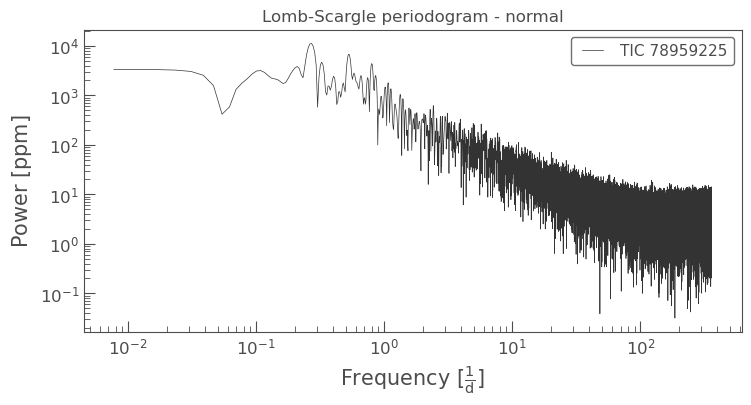

In [7]:
#Inspecting the periodogram
ax = pg_hd_lc3.plot(view='frequency', scale='log')
#ax.set_xlim(0,10)
ax.set_title('Lomb-Scargle periodogram - normal')
#plt.savefig('LS_lc3_log')

In [8]:
pg_hd_lc3.period_at_max_power   #period at max power

<Quantity 3.69130564 d>

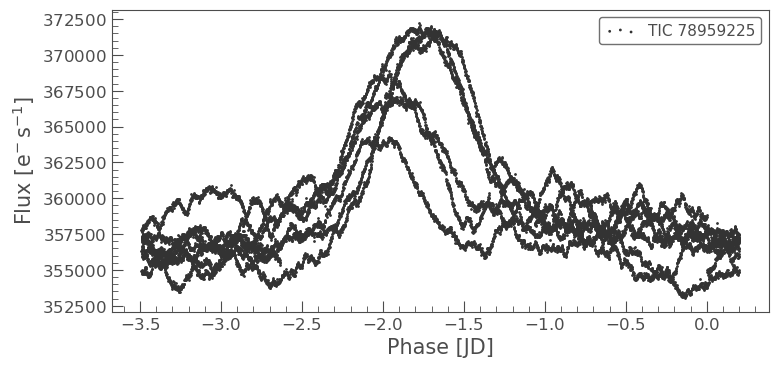

In [9]:
#Folding light curve using max power period
hd_lc3.fold(period=pg_hd_lc3.period_at_max_power, wrap_phase=0.2).scatter()

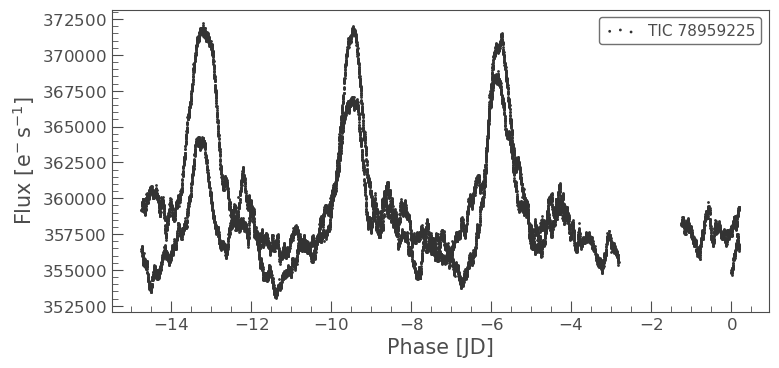

In [10]:
#Testing with folding params & then remaking periodogram
hd_lc3.fold(period=4.05*pg_hd_lc3.period_at_max_power, wrap_phase=0.2).scatter()

Hmm... Is this the best this star can do in terms of time series??? Ask Ian. 

3.7221296607237937 d


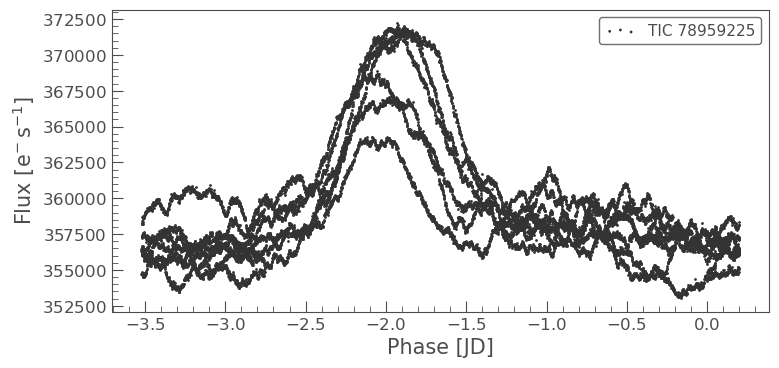

In [11]:
#Increasing oversampling frequency = 10
pg_hd_lc3 = hd_lc3.normalize(unit='ppm').to_periodogram(minimum_period=3.2*u.day, maximum_period=4.5*u.day, oversample_factor=10)
print(pg_hd_lc3.period_at_max_power)
hd_lc3.fold(period=pg_hd_lc3.period_at_max_power, wrap_phase=0.2).scatter()

Text(0.5, 1.0, 'Edited LS periodogram - oversample_f = 10; min_p = 3.2 days, max_p = 4.5 days')

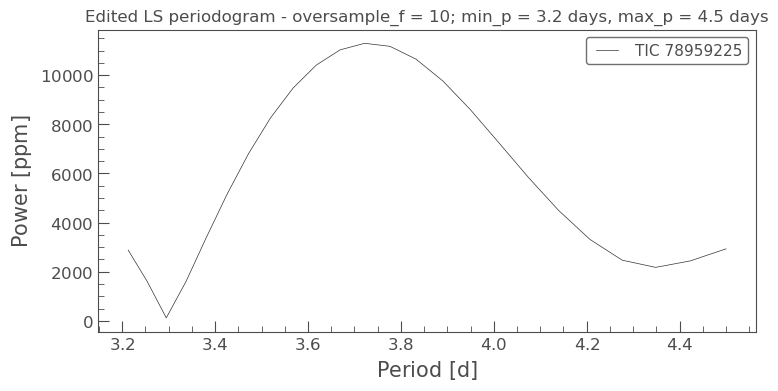

In [12]:
#Inspecting LS post-modification
ax = pg_hd_lc3.plot(view='period', scale='linear')
#ax.set_xlim(0,20)
ax.set_title('Edited LS periodogram - oversample_f = 10; min_p = 3.2 days, max_p = 4.5 days')

In [13]:
#Writing relevant light curves into ascii files
#hd_lc3.write("hd050896_lc3.txt", format="ascii.fixed_width", overwrite=True)

Text(0.5, 1.0, 'Lomb-Scargle periodogram - normal')

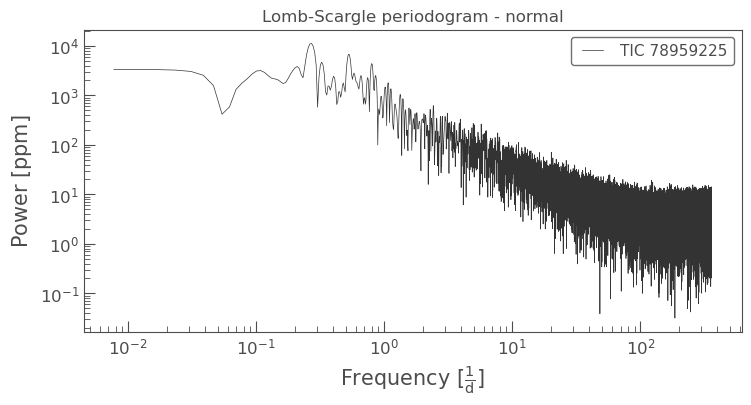

In [24]:
#Re-draw LS
short_freq = np.linspace(0.01, 400, 2000)
pg_hd_lc3 = hd_lc3.normalize(unit='ppm').to_periodogram()
x = getattr(pg_hd_lc3, 'frequency')   #frequency array
y = getattr(pg_hd_lc3, 'power')       #power (ppm) array

freq = [float(i/(1*x.unit)) for i in x]        #converting to scalars
amp_pow = [float(j/(1*y.unit)) for j in y]

ax = pg_hd_lc3.plot(view='frequency', scale='log')
ax.set_title('Lomb-Scargle periodogram - normal')

#print ((freq))

In [25]:
#Defining likelihood, flat prior and combined to probability
#a1 = v_c, a2 = gamma, a3 = C_w // x = \nu

def model(theta, freq=freq):
    a0, a1, a2, a3 = theta
    return (a0/(1+(freq/a1)**a2)) + a3

def log_likelihood(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2) 

#define flat prior
def log_prior(theta):
    a0, a1, a2, a3 = theta
    if 10**2 < a0 < 10**4 and 10**-2 < a1 < 10 and 0 < a2 < 20 and 10**-1 < a3 < 10**2:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [26]:
#Define 'true' values of a0, a1, a2, a3 and assuming an error of amplitude power
a0_true = 3*10**3
a1_true = 0.5
a2_true = 1.5
a3_true = 5
amp_err = 0.05*np.mean(amp_pow)

#Setting up for ensemble sampler
data = [freq, amp_pow, amp_err]
nwalkers = 120
niter = 3000
initial = np.array([a0_true, a1_true, a2_true, a3_true])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]


In [27]:
def main(p0,nwalkers,niter,ndim,log_probability,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 120)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,log_probability,data)

Running burn-in...
Running production...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [54:19<00:00,  1.09s/it]


In [28]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([3.23487486e+03, 8.02519161e-01, 3.00701073e+00, 8.41129061e+00])

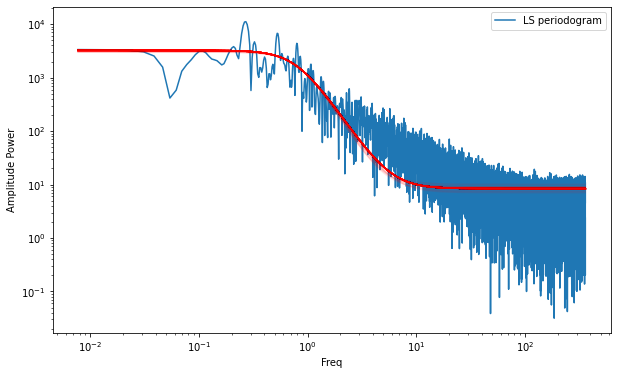

In [29]:
def plotter(sampler,freq,amp_pow):
    plt.ion()
    plt.subplots(figsize=(10, 6))
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(freq,amp_pow,label='LS periodogram')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(freq, model(theta, freq), color="r", alpha=0.1)
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Freq')
    plt.ylabel('Amplitude Power')
    plt.legend()
    plt.show()

plotter(sampler, freq, amp_pow)

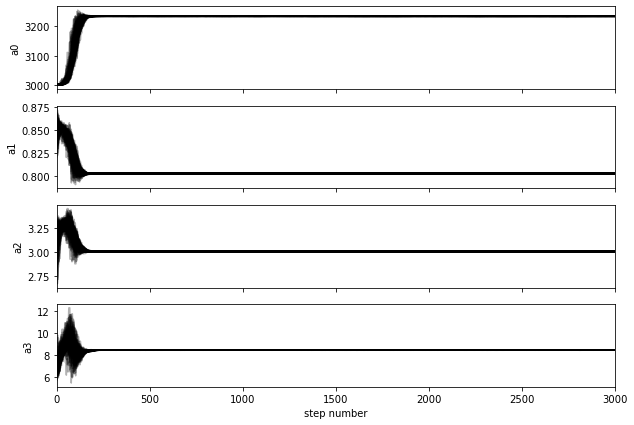

In [30]:
#Inspecting what the sampler has done
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a0", "a1", "a2", "a3"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [31]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [105.4747441   95.12925729 102.18100636  15.90166165]

In [32]:
flat_samples = sampler.get_chain(discard=250, thin=50, flat=True)
print(flat_samples.shape)

(6600, 4)


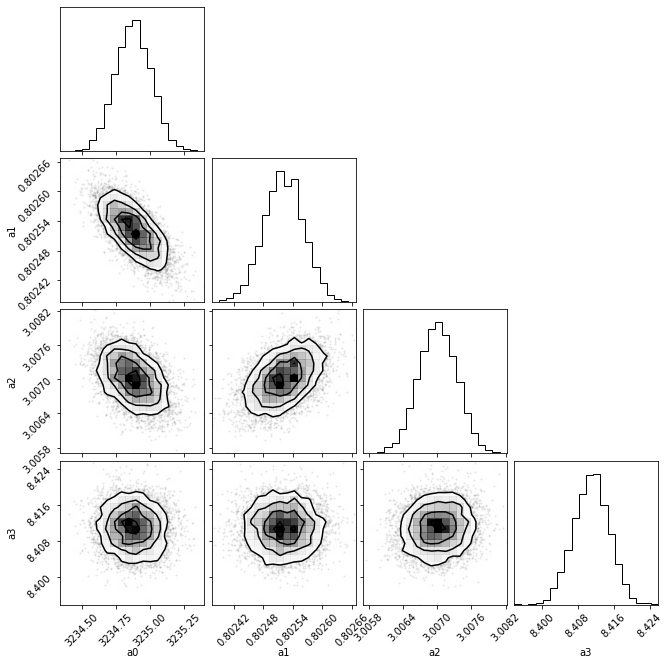

In [33]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[a0_true, a1_true, a2_true, a3_true]
);